# Boilerplate

In [1]:
# files
TRAINING_DIRECTORY = 'cnn/summary/'
EXTENSION = '.question'
N_TRAIN_FILES = 40000
N_TEST_FILES = 500

# tokenization
FILTERS = ''
PAD_CHAR = '@pad'
INPUT_END_CHAR = '@input-end'
TARGET_END_CHAR = '@target-end'
OOV_CHAR = '@unk'
PAD_TOKEN = 0
INPUT_END_TOKEN = 1
TARGET_END_TOKEN = 2
OOV_TOKEN = 3

# MODEL_PARAMS
MAX_INPUT_LEN = 150
MAX_TARGET_LEN = 20
MAX_TOTAL_LEN = MAX_INPUT_LEN + MAX_TARGET_LEN
NUM_WORDS = 15000

# Read in files

In [2]:
import glob

In [3]:
FILES = glob.glob('%s/*%s' % (TRAINING_DIRECTORY, EXTENSION))
print(len(FILES))
FILES

380298


['cnn/summary/239c17682016c0c244cdf46200c5f740c8a2c9db.question',
 'cnn/summary/65c7b28e3ba0dacc5a85ab3ea1c9a635744bdf83.question',
 'cnn/summary/dc65fd491d2ac61c83037e5c1338cf6de19f95ee.question',
 'cnn/summary/603b08f191ac8bf06df441619dd912f446179065.question',
 'cnn/summary/0b3c640ebc44567eb3beb8b8297638d7090e8384.question',
 'cnn/summary/a3c5386bc005ef369b70267a5b4248b37052b64a.question',
 'cnn/summary/4dfd23aa3de5205cfe91b091b5365994105d29ba.question',
 'cnn/summary/36b0c8f1069460e5d997ad66c4ebff1c350c5000.question',
 'cnn/summary/18062cf32b6e91bbfa45e8645317499d417e2d87.question',
 'cnn/summary/b01d1b7f5bc30e17d727de4d8d85245b8ff2ffd0.question',
 'cnn/summary/530c4400a0a83900c2810e2795607af94a2447a5.question',
 'cnn/summary/9f17668a9cd8170fdad9788ed64e489e468cf9c3.question',
 'cnn/summary/3eb19c15e3b126ef702183f031e6bedfd8276ed9.question',
 'cnn/summary/198bf4f7ed30c58ad769029dc18f28c843172ae3.question',
 'cnn/summary/20ba1ddd872afe8f10f0242838ff76ede6e1d200.question',
 'cnn/summ

In [4]:
TRAIN_FILES = FILES[:N_TRAIN_FILES]
TEST_FILES = FILES[N_TRAIN_FILES:N_TRAIN_FILES+N_TEST_FILES]

# Define batch generator

In [34]:
import random
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from data import BaseBatchGenerator

class SummaryBatchGenerator(BaseBatchGenerator):
    def __init__(self, tokenizer, num_words, decoder_input_len,
                 decoder_target_len, input_end_token, target_end_token,
                 pad_token):
        self.tokenizer = tokenizer
        self.num_words = num_words
        self.decoder_input_len = decoder_input_len
        self.decoder_target_len = decoder_target_len
        self.sentence_len = self.decoder_input_len + self.decoder_target_len
        self.input_end_token = input_end_token
        self.target_end_token = target_end_token
        self.pad_token = pad_token

    def generate_batches(self, steps, batch_size, n_batches):
        for i in range(n_batches):
            start, stop = i*batch_size, (i+1)*batch_size
            batch_steps = steps[start:stop]
            encoder_steps, decoder_steps = zip(*batch_steps)
            x1 = np.array(encoder_steps)
            x2 = np.array(decoder_steps)
            # offset target from decoder input
            X = [x1, x2[:,:-1]]
            y = x2[:,1:]
            yield X, y

    def generate_steps(self, item):
        training_example = self.process_file(item)
        if len(training_example.target_tokens) > self.decoder_target_len:
            return []
        encoder_tokens = training_example.input_tokens[:self.sentence_len]
        decoder_tokens = training_example.input_tokens[:self.decoder_input_len] \
                       + [self.input_end_token] \
                       + training_example.target_tokens \
                       + [self.target_end_token]
        example = self.pad(encoder_tokens), self.pad(decoder_tokens, prepend=True)
        return [example]

    def process_file(self, file):
        input_text, target_text = self.read_file(file)
        input_tokens = self.tokenizer([input_text])[0]
        target_tokens = self.tokenizer([target_text])[0]
        training_example = TrainingExample(file, input_text, target_text,
                                           input_tokens, target_tokens)
        return training_example

    @staticmethod
    def read_file(file):
        with open(file) as f:
            context, target = f.read().split('\t')
        return context, target

    def batches_per_epoch(self, items, batch_size):
        steps = sum(len(self.process_file(f).target_tokens) for f in items)
        return steps // batch_size
    
    def pad(self, tokens, prepend=False):
        # add 1 to sentence_len since we shift output one step forward to prevent
        # model from attending to future time steps
        tokens = pad_sequences(
            [tokens], maxlen=self.sentence_len, padding='post',
            truncating='post', value=self.pad_token)
        if prepend:
            tokens = pad_sequences(
                [tokens[0]], maxlen=self.sentence_len+1, padding='pre',
                value=self.pad_token)
        return tokens[0]

class TrainingExample:
    def __init__(self, item, input_text, target_text, input_tokens,
                 target_tokens):
        self.item = item
        self.input_text = input_text
        self.target_text = target_text
        self.input_tokens = input_tokens
        self.target_tokens = target_tokens

# Initialize Tokenizer

In [6]:
from tokenization import Tokenizer

In [7]:
tokenizer = Tokenizer(
    num_words=NUM_WORDS,
    filters=FILTERS,
    oov_token=OOV_CHAR)

In [8]:
text_gen = (text for f in TRAIN_FILES+TEST_FILES for text in SummaryBatchGenerator.read_file(f))

In [9]:
%%time
tokenizer.fit_on_texts(text_gen)

CPU times: user 18.3 s, sys: 240 ms, total: 18.5 s
Wall time: 18.6 s


In [10]:
print('TOKENIZER.num_words', tokenizer.num_words)
print('len(TOKENIZER.word_index)', len(tokenizer.word_index))
tokenizer.word_index

TOKENIZER.num_words 15000
len(TOKENIZER.word_index) 79411


{'temperamentally': 41448,
 'rendezvous': 18838,
 'post-oscar': 52438,
 '24.kg': 52730,
 'loped': 73253,
 'pre-oscar': 64316,
 'sensibly': 28785,
 'contend': 5370,
 '4852': 72819,
 'restart': 8972,
 'hooliganism': 15461,
 'hexacopter': 67589,
 'blowouts': 27834,
 'fuhrer': 71805,
 '829': 30238,
 '9/7': 51676,
 'imprisoning': 21970,
 'harpoon': 76439,
 'katydid': 57459,
 'murdoch': 56544,
 'tills': 77302,
 'noisily': 37246,
 'resulted': 3057,
 '199.6': 59471,
 '9:48': 43110,
 'entitlements': 16043,
 'covers': 4440,
 'zits': 70774,
 'autosport.com': 37367,
 '4.189': 55099,
 '1.59': 69499,
 'sprawl': 24705,
 'part': 201,
 'tailed': 22324,
 'cyclobenzaprine': 43375,
 'connote': 57540,
 'fireman': 21725,
 'buccaneer': 78141,
 '847.5': 61125,
 'ultimatum': 13155,
 'endows': 55027,
 'route': 2431,
 'downcast': 37608,
 'unpicked': 67354,
 'demagogue': 27872,
 'jars': 19492,
 'wordbanks': 47308,
 'weirdly': 25263,
 'sub-type': 52652,
 'schizotypy': 33502,
 'capturer': 77323,
 'unluckiest': 4917

In [11]:
index_to_word = {v: k for k, v in tokenizer.word_index.items()}
index_to_word[PAD_TOKEN] = PAD_CHAR
index_to_word[INPUT_END_TOKEN] = INPUT_END_CHAR
index_to_word[TARGET_END_TOKEN] = TARGET_END_CHAR

In [12]:
sorted(index_to_word.items(), key=lambda x: x[0])

[(0, '@pad'),
 (1, '@input-end'),
 (2, '@target-end'),
 (3, '@unk'),
 (4, 'the'),
 (5, ','),
 (6, '.'),
 (7, 'to'),
 (8, '"'),
 (9, 'of'),
 (10, 'and'),
 (11, 'a'),
 (12, 'in'),
 (13, "'s"),
 (14, 'that'),
 (15, 'for'),
 (16, 'is'),
 (17, '-'),
 (18, 'on'),
 (19, 'it'),
 (20, 'said'),
 (21, 'was'),
 (22, 'he'),
 (23, 'with'),
 (24, 'as'),
 (25, 'i'),
 (26, 'his'),
 (27, '--'),
 (28, '@entity1'),
 (29, 'at'),
 (30, 'have'),
 (31, 'from'),
 (32, 'but'),
 (33, 'are'),
 (34, 'be'),
 (35, 'has'),
 (36, 'by'),
 (37, 'this'),
 (38, 'not'),
 (39, '@entity2'),
 (40, 'an'),
 (41, 'we'),
 (42, 'they'),
 (43, '@entity3'),
 (44, '@entity0'),
 (45, 'who'),
 (46, '@entity4'),
 (47, 'will'),
 (48, ')'),
 (49, '('),
 (50, "n't"),
 (51, 'you'),
 (52, ':'),
 (53, 'were'),
 (54, 'their'),
 (55, 'had'),
 (56, '@entity5'),
 (57, 'she'),
 (58, 'been'),
 (59, 'about'),
 (60, 'one'),
 (61, 'more'),
 (62, 'after'),
 (63, 'her'),
 (64, '@entity6'),
 (65, 'or'),
 (66, 'there'),
 (67, 'when'),
 (68, 'people'),
 (6

In [13]:
tokenizer.num_words = min(len(tokenizer.word_index)+1, tokenizer.num_words)
NUM_WORDS = tokenizer.num_words

In [14]:
TOKENIZER = tokenizer.texts_to_sequences

# Take a look at batches

In [35]:
batch_gen = SummaryBatchGenerator(
    tokenizer=TOKENIZER,
    num_words=NUM_WORDS,
    decoder_input_len=MAX_INPUT_LEN,
    decoder_target_len=MAX_TARGET_LEN,
    input_end_token=INPUT_END_TOKEN,
    target_end_token=TARGET_END_TOKEN,
    pad_token=PAD_TOKEN
).generate_forever(TRAIN_FILES, batch_size=32)

In [37]:
X, y = next(batch_gen)
x1, x2 = X

In [38]:
x1.shape, x2.shape, y.shape

((32, 170), (32, 170), (32, 170))

In [39]:
X

[array([[   49,    44,    48, ...,   249,     7,   374],
        [   49,    44,    48, ...,     0,     0,     0],
        [   49,    44,    48, ...,     6,     8,    46],
        ...,
        [   49,    44,    48, ...,    27,    23,   276],
        [   49,    44,    48, ...,    40, 11304,   812],
        [   49,    44,    48, ...,     6,     8,    22]], dtype=int32),
 array([[ 0, 49, 44, ...,  0,  0,  0],
        [ 0, 49, 44, ...,  0,  0,  0],
        [ 0, 49, 44, ...,  0,  0,  0],
        ...,
        [ 0, 49, 44, ...,  0,  0,  0],
        [ 0, 49, 44, ...,  0,  0,  0],
        [ 0, 49, 44, ...,  2,  0,  0]], dtype=int32)]

In [40]:
y

array([[49, 44, 48, ...,  0,  0,  0],
       [49, 44, 48, ...,  0,  0,  0],
       [49, 44, 48, ...,  0,  0,  0],
       ...,
       [49, 44, 48, ...,  0,  0,  0],
       [49, 44, 48, ...,  0,  0,  0],
       [49, 44, 48, ...,  0,  0,  0]], dtype=int32)

In [64]:
def view_training_examples(x1, x2, y):
    print(' '.join([index_to_word[i] for i in x1]))
    print('\n\n')
    print(' '.join([index_to_word[i] for i in x2]))
    print('\n\n')
    print(' '.join([index_to_word[i] for i in y]))

In [65]:
examples = zip(x1, x2, y)

In [66]:
view_training_examples(*next(examples))

( @entity0 ) -- a man accused of crimes against humanity who has evaded @entity7 warrants for seven years has surrendered to the @entity8 in @entity9 , @entity10 , officials said monday . " i can confirm that this morning @entity11 ... walked into @entity12 @entity9 . he specifically asked to be transferred to the @entity7 in the @entity13 . we 're currently consulting with a number of governments , including the @entity10 government , in order to facilitate his request , " @entity15 spokeswoman @entity14 told reporters . she said she did n't think @entity12 authorities had any advance notice that he would surrender . news of @entity11 turning himself in was also reported in a @entity29 post from @entity10 minister of foreign affairs @entity30 . the @entity7 first issued an arrest warrant for @entity11 , who at different times has been a @entity33 rebel leader and a general in the army of the @entity33 , in 2006 . that warrant alleged that @entity11 had forced children to become



@pa

# Training

In [22]:
from keras.optimizers import adam

In [73]:
# model architecture
N_HEADS = 8
N_LAYERS = 4
D_MODEL = 64*N_HEADS
SENTENCE_LEN = MAX_TOTAL_LEN
VOCAB_SIZE = NUM_WORDS
DROPOUT = 0.1

# batch training
N_EPOCHS = 1000
WARMUP_STEPS = 10
BATCH_SIZE = 32
CALLBACKS = []

# optimization
# https://arxiv.org/pdf/1804.00247.pdf
OPTIMIZER = adam(lr=1e-5, beta_1=0.9, beta_2=0.98, epsilon=1e-9, clipnorm=2.0)

In [69]:
batch_gen = SummaryBatchGenerator(
    tokenizer=TOKENIZER,
    num_words=NUM_WORDS,
    decoder_input_len=MAX_INPUT_LEN,
    decoder_target_len=MAX_TARGET_LEN,
    input_end_token=INPUT_END_TOKEN,
    target_end_token=TARGET_END_TOKEN,
    pad_token=PAD_TOKEN
)

In [70]:
%%time
TRAIN_STEPS_PER_EPOCH = batch_gen.batches_per_epoch(TRAIN_FILES, batch_size=BATCH_SIZE)
print('train steps per epoch', TRAIN_STEPS_PER_EPOCH)

train steps per epoch 15574
CPU times: user 15.6 s, sys: 200 ms, total: 15.8 s
Wall time: 15.8 s


In [71]:
%%time
TEST_STEPS_PER_EPOCH = batch_gen.batches_per_epoch(TEST_FILES, batch_size=BATCH_SIZE)
print('train steps per epoch', TEST_STEPS_PER_EPOCH)

train steps per epoch 197
CPU times: user 216 ms, sys: 0 ns, total: 216 ms
Wall time: 212 ms


In [72]:
Xy_train = batch_gen.generate_forever(TRAIN_FILES, batch_size=BATCH_SIZE)
Xy_test = batch_gen.generate_forever(TEST_FILES, batch_size=BATCH_SIZE)

In [75]:
from model import Transformer
model = Transformer(
    n_heads=N_HEADS,
    encoder_layers=N_LAYERS,
    decoder_layers=N_LAYERS,
    d_model=D_MODEL,
    vocab_size=VOCAB_SIZE,
    sequence_len=SENTENCE_LEN,
    dropout=DROPOUT,
    sparse=True)

In [76]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
encoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 170, 512)     7680000     encoder_input[0][0]              
                                                                 decoder_input[0][0]              
__________________________________________________________________________________________________
positional_encoding_1 (Position (None, 170, 512)     0           embedding[0][0]                  
          

In [77]:
import tensorflow as tf
import keras.backend as K

def sparse_categorical_crossentropy(y_true, y_pred):
    return tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)

def perplexity(y_true, y_pred):
    cross_entropy = sparse_categorical_crossentropy(y_true, y_pred)
    return K.exp(cross_entropy)

METRICS = [sparse_categorical_crossentropy]
LOSS = perplexity

In [78]:
class LRScheduler:
    """Stateful learning rate scheduler.
    
    Useful if training is stopped and then resumed so that scheduling
    resumes considering the epoch during which training was interrupted.
    """
    def __init__(self, d_model, warmup_steps):
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.reset_epoch()

    def lr(self, *args):
        lr = self.d_model**-.5 * min(self.epoch**-.5, self.epoch*(self.warmup_steps**-1.5))
        self.epoch += 1
        return lr
    
    def __enter__(self):
        self.reset_epoch()
        return self
    
    def __exit__(self, *exc):
        self.reset_epoch()
        return False
    
    def reset_epoch(self):
        self.epoch = 1
    
lr_scheduler = LRScheduler(D_MODEL, WARMUP_STEPS)

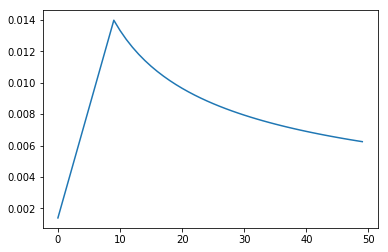

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline
with lr_scheduler:
    learning_rates = [lr_scheduler.lr() for _ in range(0, 50, 1)]
plt.plot(learning_rates)

In [81]:
from keras.callbacks import LearningRateScheduler
CALLBACKS.append(LearningRateScheduler(lr_scheduler.lr))

In [82]:
TARGET_PLACEHOLDER = tf.placeholder(dtype='int32', shape=(None, SENTENCE_LEN))
model.compile(
    loss=LOSS,
    optimizer=OPTIMIZER,
    metrics=METRICS,
    target_tensors=[TARGET_PLACEHOLDER])

In [83]:
# print loss value references
def display_loss_reference():
    format_ = 'perplexity: %20s\tentropy: %20s'
    upper_limit = np.log(VOCAB_SIZE)
    print(format_ % (np.exp(upper_limit), upper_limit))
    for i in reversed(range(int(np.floor(upper_limit))+1)):
        print(format_ % (np.exp(i), i))
display_loss_reference()

perplexity:   15000.000000000004	entropy:    9.615805480084347
perplexity:    8103.083927575384	entropy:                    9
perplexity:   2980.9579870417283	entropy:                    8
perplexity:   1096.6331584284585	entropy:                    7
perplexity:    403.4287934927351	entropy:                    6
perplexity:    148.4131591025766	entropy:                    5
perplexity:   54.598150033144236	entropy:                    4
perplexity:   20.085536923187668	entropy:                    3
perplexity:     7.38905609893065	entropy:                    2
perplexity:    2.718281828459045	entropy:                    1
perplexity:                  1.0	entropy:                    0


In [ ]:
model.fit_generator(
    Xy_train,
    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
    epochs=N_EPOCHS,
    validation_data=Xy_test,
    validation_steps=TEST_STEPS_PER_EPOCH,
    callbacks=CALLBACKS)

Epoch 1/1000
  239/15574 [..............................] - ETA: 2:59:38 - loss: 4955.1599 - sparse_categorical_crossentropy: 7.5938